# Implementing a Convolutional Autoencoder in Pytorch on the Omniglot Dataset

## A brief description of autoencoders



An autoencoder is a type of neural network used for unsupervised learning, typically for tasks like dimensionality reduction, feature extraction, or data denoising. It consists of two main parts:

- Encoder: This part compresses the input data into a lower-dimensional representation, called the "latent space" or "code." It learns to capture the most important features of the input.

- Decoder: This part reconstructs the original input from the compressed latent representation. The goal is for the output to be as close as possible to the input, thus minimizing the reconstruction error.

<center>
    <div>
    <img src='../assets/conv_autoencoder_architecture.png' heihgt=600 width=800>
    </div>
</center>


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [42]:
# to make the code device-agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## About the dataset

THe **Omniglot**is a collection of handwritten characters designed for developing and testing algorithms in areas such as few-shot learning and meta-learning, it contains 1,623 different characters from 50 different alphabets. Each character has 20 examples written by different individuals.Characters are stored in individual folders, and each example is a black-and-white 105x105 image.It also includes "background" and "evaluation" sets, used to train and test meta-learning algorithms.


In [43]:
available_datasets = [item for item in dir(datasets) if not item.startswith("_")]
print(f"Available datasets : {available_datasets}")
print("=" * 65)
print(
    f"Is the Omniglot dataset provided in torchvison datasets? : {'Omniglot' in available_datasets}"
)

Available datasets : ['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'Imagenette', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', 'caltech', 'celeba'

In [44]:
import os
from icecream import ic
from pathlib import Path


def walk_omniglot_dir(base_dir: Path):
    """
    Walks through the Omniglot directory and collects statistics about each directory (language class)
    """
    stats = {}
    for language in os.listdir(base_dir):
        language_path = os.path.join(base_dir, language)
        if os.path.isdir(language_path):
            sample_count = 0
            # iter throgh characters of each lang
            for character in os.listdir(language_path):
                character_path = os.path.join(language_path, character)
                if os.path.isdir(character_path):
                    samples = [
                        f
                        for f in os.listdir(character_path)
                        if os.path.isfile(os.path.join(character_path, f))
                    ]
                    sample_count += len(samples)
            stats[language] = sample_count
    return stats


base_dir = Path("../data/omniglot-py/images_background")
stats = walk_omniglot_dir(base_dir)
# added the ; to suppress interactive expression output to avoid duplicated dipslay with ic
ic(stats);

ic| stats: {'Alphabet_of_the_Magi': 400,
            'Anglo-Saxon_Futhorc': 580,
            'Arcadian': 520,
            'Armenian': 820,
            'Asomtavruli_(Georgian)': 800,
            'Balinese': 480,
            'Bengali': 920,
            'Blackfoot_(Canadian_Aboriginal_Syllabics)': 280,
            'Braille': 520,
            'Burmese_(Myanmar)': 680,
            'Cyrillic': 660,
            'Early_Aramaic': 440,
            'Futurama': 520,
            'Grantha': 860,
            'Greek': 480,
            'Gujarati': 960,
            'Hebrew': 440,
            'Inuktitut_(Canadian_Aboriginal_Syllabics)': 320,
            'Japanese_(hiragana)': 1040,
            'Japanese_(katakana)': 940,
            'Korean': 800,
            'Latin': 520,
            'Malay_(Jawi_-_Arabic)': 800,
            'Mkhedruli_(Georgian)': 820,
            'N_Ko': 660,
            'Ojibwe_(Canadian_Aboriginal_Syllabics)': 280,
            'Sanskrit': 840,
            'Syriac_(Estrangelo)': 460,

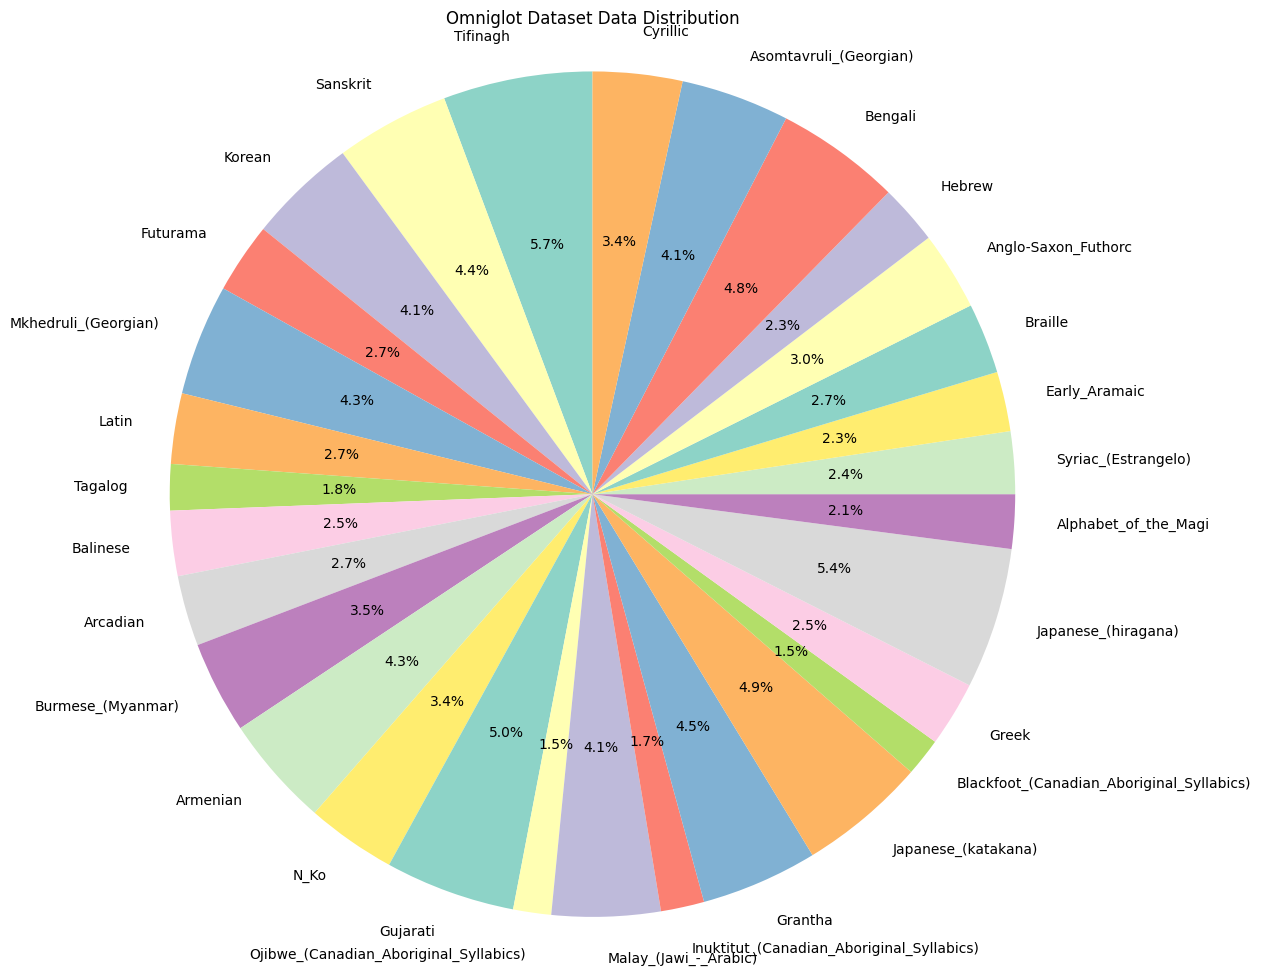

In [45]:
def plot_data_distribution(
    stats: Dict, title: str = "Omniglot Dataset Data Distribution"
):
    """
    Plots a pie chart representing the distribution of the Omniglob dataset languages samples
    """

    labels = list(stats.keys())
    values = list(stats.values())
    # cause sns colors just look cooler :)
    colors = sns.color_palette("Set3", len(stats))
    plt.figure(figsize=(12, 12))
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
    plt.title(title)
    plt.axis("equal")
    plt.show()


plot_data_distribution(stats)

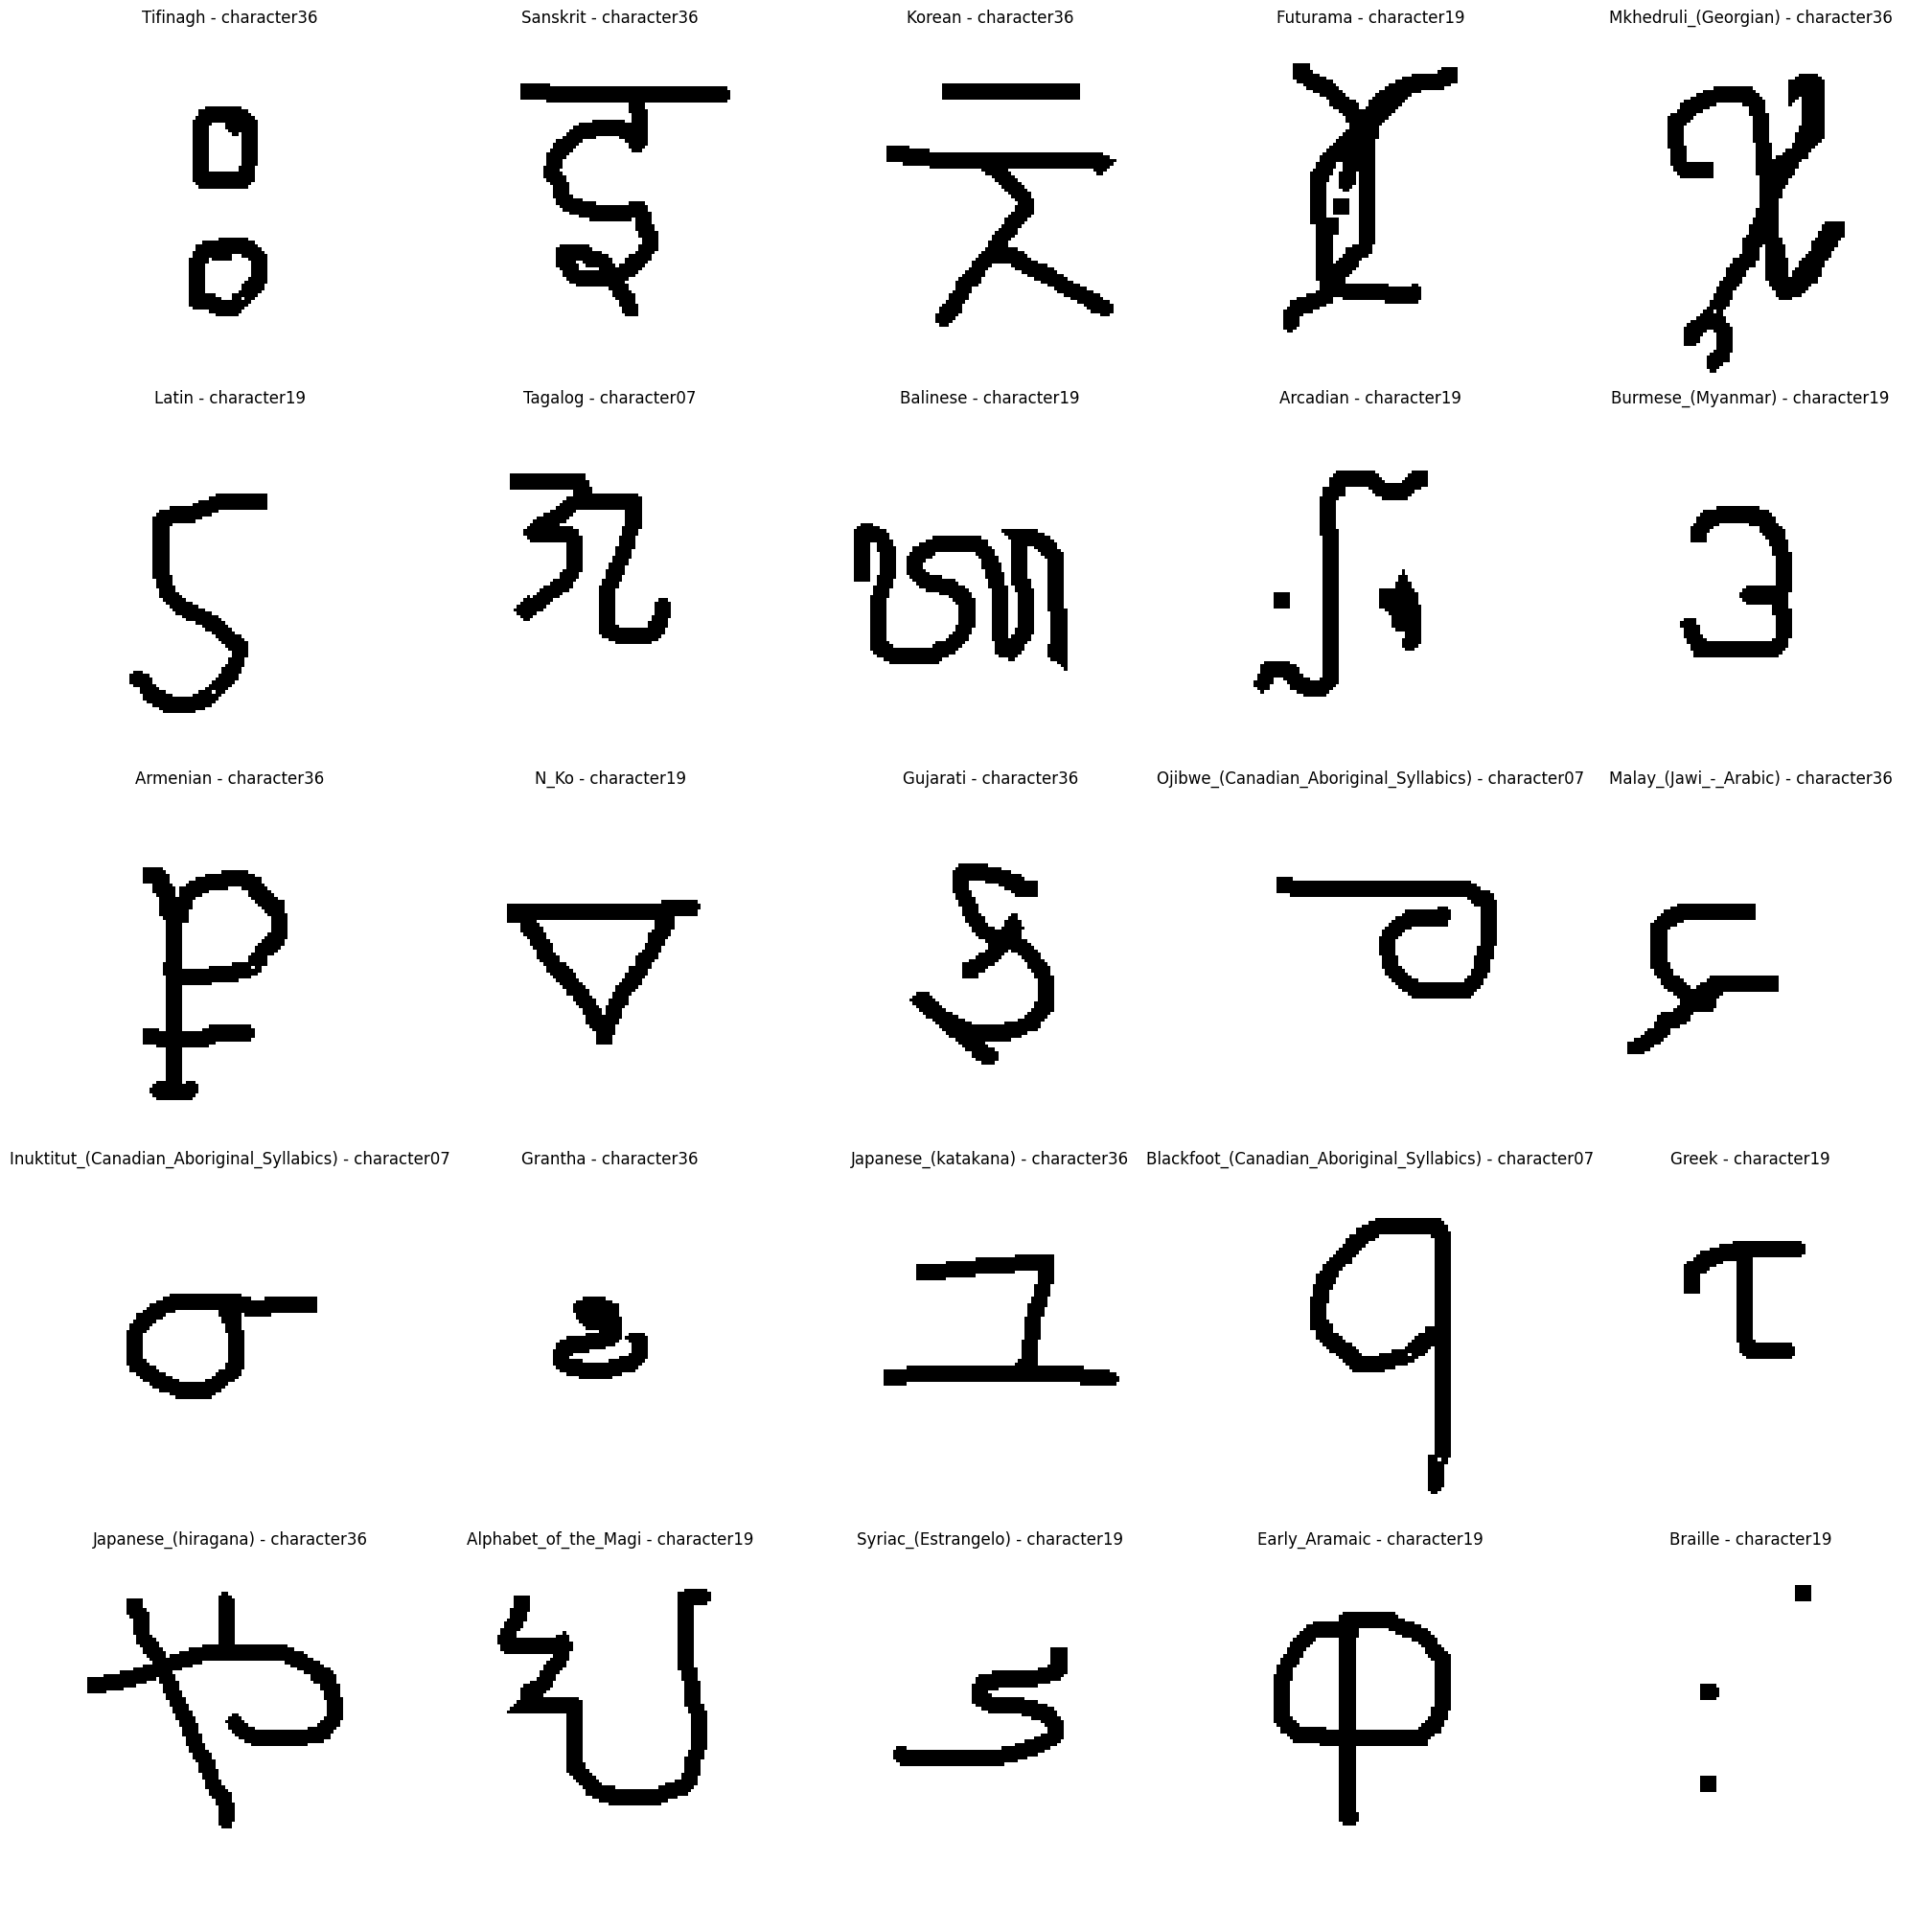

In [46]:
def plot_samples(base_dir: Path):
    """
    Plots one sample image from the first character of each language in the Omniglot dataset.
    """
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    axes = axes.flatten()
    idx = 0
    # iter through langs
    for language in os.listdir(base_dir):
        if idx >= len(axes):
            break
        language_path = os.path.join(base_dir, language)
        if os.path.isdir(language_path):
            # get the first character foder ( we just take the first image sample character file)
            characters = [
                c
                for c in os.listdir(language_path)
                if os.path.isdir(os.path.join(language_path, c))
            ]
            if characters:
                first_character = characters[0]
                character_path = os.path.join(language_path, first_character)
                samples = [
                    f
                    for f in os.listdir(character_path)
                    if os.path.isfile(os.path.join(character_path, f))
                ]
                if samples:
                    image_path = os.path.join(character_path, samples[0])
                    image = plt.imread(image_path)
                    axes[idx].imshow(image, cmap="gray")
                    axes[idx].axis("off")
                    axes[idx].set_title(f"{language} - {first_character}")
                    idx += 1
    plt.tight_layout()
    plt.show()


base_dir = Path("../data/omniglot-py/images_background")
plot_samples(base_dir)

In [47]:
# we'll just trun the images to pt tensors
transforms = transforms.ToTensor()

omniglot_data = datasets.Omniglot(root="../data", download=True, transform=transforms)

Files already downloaded and verified


In [48]:
print(omniglot_data.__doc__)

`Omniglot <https://github.com/brendenlake/omniglot>`_ Dataset.

    Args:
        root (str or ``pathlib.Path``): Root directory of dataset where directory
            ``omniglot-py`` exists.
        background (bool, optional): If True, creates dataset from the "background" set, otherwise
            creates from the "evaluation" set. This terminology is defined by the authors.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset zip files from the internet and
            puts it in root directory. If the zip files are already downloaded, they are not
            downloaded again.
    


In [49]:
print(omniglot_data)

Dataset Omniglot
    Number of datapoints: 19280
    Root location: ../data/omniglot-py
    StandardTransform
Transform: ToTensor()


Next we will organize our data in dataloaders. A DataLoader is responsible for managing the process of batching, shuffling, and loading data efficiently during model training or evaluation. 

| **Parameter**      | **Value**            | **Description**                                                                 |
|---------------------|----------------------|---------------------------------------------------------------------------------|
| `dataset`          | `omniglot_data`      | The dataset to load data from.                                                 |
| `batch_size`       | `64`                 | Number of samples per batch.                                                   |
| `shuffle`          | `True`               | Whether to shuffle the data at each epoch.                                     |
| `num_workers`      | `0`                  | Number of subprocesses to use for data loading.                                |
| `pin_memory`       | `False`              | Whether to pin memory to speed up GPU


In [50]:
data_loader = torch.utils.data.DataLoader(
    dataset=omniglot_data, batch_size=64, shuffle=True
)

In [51]:
# we set the seed for reproducibility
seed = 22  # cause i'm 22 :)
torch.manual_seed(seed)

train_size = int(0.8 * len(omniglot_data))
test_size = len(omniglot_data) - train_size

train_dataset, test_dataset = random_split(omniglot_data, [train_size, test_size])

print(f"Training data size: {len(train_dataset)}")
print(f"Testing data size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training data size: 15424
Testing data size: 3856


In [52]:
first_batch, _ = next(iter(train_loader))
first_element_shape = first_batch[0].shape

print("Shape of the first element in the first batch:", first_element_shape)

Shape of the first element in the first batch: torch.Size([1, 105, 105])


In [53]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## Define the architecture of the autoencoder

In [54]:
import torch
import torch.nn as nn
from torchsummary import summary


class AutoEncoderImg(nn.Module):
    def __init__(self):
        super(AutoEncoderImg, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # 1st conv layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 2nd conv layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 3rd conv layer (removed 4th layer)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            # 1st ConvTranspose layer
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=1, padding=1, output_padding=0
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 2nd ConvTranspose layer
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=1, padding=1, output_padding=0
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 3rd ConvTranspose layer (final output)
            nn.ConvTranspose2d(
                32, 1, kernel_size=3, stride=1, padding=1, output_padding=0
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_summary(self, input_size=(1, 105, 105)):
        """
        Summarize the model's architecture using torchsummary.
        """
        summary(self, input_size=input_size)


def test_autoencoder():
    """To test the image shape after reconstruction"""
    model = AutoEncoderImg()
    input_image = torch.randn(1, 1, 105, 105)
    output_image = model(input_image)
    print(f"Input shape: {input_image.shape}")
    print(f"Output shape: {output_image.shape}")
    assert input_image.shape == output_image.shape, "Input and output size mismatch!"
    return model


# Test the simplified model
model = test_autoencoder()

Input shape: torch.Size([1, 1, 105, 105])
Output shape: torch.Size([1, 1, 105, 105])


In [55]:
model = AutoEncoderImg().to(device)

In [56]:
model.get_summary(input_size=(1, 105, 105))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 105, 105]             320
       BatchNorm2d-2         [-1, 32, 105, 105]              64
              ReLU-3         [-1, 32, 105, 105]               0
            Conv2d-4         [-1, 64, 105, 105]          18,496
       BatchNorm2d-5         [-1, 64, 105, 105]             128
              ReLU-6         [-1, 64, 105, 105]               0
            Conv2d-7        [-1, 128, 105, 105]          73,856
       BatchNorm2d-8        [-1, 128, 105, 105]             256
              ReLU-9        [-1, 128, 105, 105]               0
  ConvTranspose2d-10         [-1, 64, 105, 105]          73,792
      BatchNorm2d-11         [-1, 64, 105, 105]             128
             ReLU-12         [-1, 64, 105, 105]               0
  ConvTranspose2d-13         [-1, 32, 105, 105]          18,464
      BatchNorm2d-14         [-1, 32, 1

# Detailing the architecture of the defined Autoencoder


## 1. Encoder
The encoder progressively reduces the spatial dimensions (height and width) while increasing the number of feature channels. This helps learn a compact representation in the latent space.

### 1.1 Convolutional Layers
- **`nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)`**
  - Input channels: `1` (grayscale images)
  - Output channels: `32`
  - Kernel size: `3`
  - Stride: `1` (maintains the spatial dimensions)
  - Padding: `1` (ensures no reduction in dimensions)
  
- **`nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)`**
  - Input channels: `32`
  - Output channels: `64`
  - Kernel size: `3`
  - Stride: `1`
  - Padding: `1`
  
- **`nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)`**
  - Input channels: `64`
  - Output channels: `128`
  - Kernel size: `3`
  - Stride: `1`
  - Padding: `1`

### 1.2 Image Shape Transformations
Assume the input image has the shape `(batch_size, 1, H, W)`. Since the stride is `1`, the spatial dimensions are preserved after each convolutional layer:

- After the first convolution, the output shape is `(batch_size, 32, H, W)`.
- After the second convolution, it becomes `(batch_size, 64, H, W)`.
- After the third convolution, it becomes `(batch_size, 128, H, W)`.

---

## 2. Decoder
The decoder reverses the encoding process. It uses transposed convolution layers to reconstruct the original image from the compressed representation.

### 2.1 Transposed Convolutional Layers
- **`nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, output_padding=0)`**
  - Input channels: `128`
  - Output channels: `64`
  - Kernel size: `3`
  - Stride: `1`
  - Padding: `1`
  - Output padding: `0`
  
- **`nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0)`**
  - Input channels: `64`
  - Output channels: `32`
  - Kernel size: `3`
  - Stride: `1`
  - Padding: `1`
  - Output padding: `0`
  
- **`nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1, output_padding=0)`**
  - Input channels: `32`
  - Output channels: `1` (grayscale image)
  - Kernel size: `3`
  - Stride: `1`
  - Padding: `1`
  - Output padding: `0`
  - **Activation:** Sigmoid function to ensure output values are in the range `[0, 1]`.

### 2.2 Image Shape Transformations
The decoder starts with an input of shape `(batch_size, 128, H, W)` and reconstructs it back to `(batch_size, 1, H, W)`:

- After the first transposed convolution, the shape becomes `(batch_size, 64, H, W)`.
- After the second transposed convolution, it becomes `(batch_size, 32, H, W)`.
- After the final transposed convolution, it becomes `(batch_size, 1, H, W)`.








### Additional Notes

To calculate the output shape of a regular convolution layer, we use the formula:

$$
\text{Output size} = \left\lfloor \frac{\text{Input size} + 2 \cdot \text{Padding} - \text{Kernel size}}{\text{Stride}} \right\rfloor + 1
$$

For transposed convolution, we use this formula:

$$
\text{Output size} = (\text{Input size} - 1) \cdot \text{Stride} - 2 \cdot \text{Padding} + \text{Kernel size} + \text{Output Padding}
$$




In [57]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)

In [58]:
def plot_loss(train_losses: List[float], test_losses: List[float]) -> None:
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(
        epochs,
        train_losses,
        marker="o",
        linestyle="-",
        color="b",
        label="Training Loss",
    )
    plt.plot(
        epochs, test_losses, marker="o", linestyle="--", color="r", label="Test Loss"
    )
    plt.title("Training and Test Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.legend()
    plt.grid()
    plt.show()

In [59]:
num_epochs: int = 3
train_losses: List[float] = []
test_losses: List[float] = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for img, label in progress_bar:
        img = img.to(device)
        reconstructed_img = model(img)
        loss = criterion(reconstructed_img, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.6f}")

    avg_train_loss = epoch_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}")

    # Testing
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            reconstructed_img = model(img)
            loss = criterion(reconstructed_img, img)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}: Test Loss = {avg_test_loss:.6f}")

Epoch 1/3:   0%|          | 0/302 [00:10<?, ?it/s]


KeyboardInterrupt: 

 ### Note:

Since training takes long on my machine (on cpu), I used [Colab](https://colab.research.google.com/drive/11EaFlEx7nkWLr57LPxfiUdd5ax5QMnAl#scrollTo=OzHVCcE-PQUy) to train and cache the model. then downloaded the cached model locally for inference.

Here are the obtained losses:


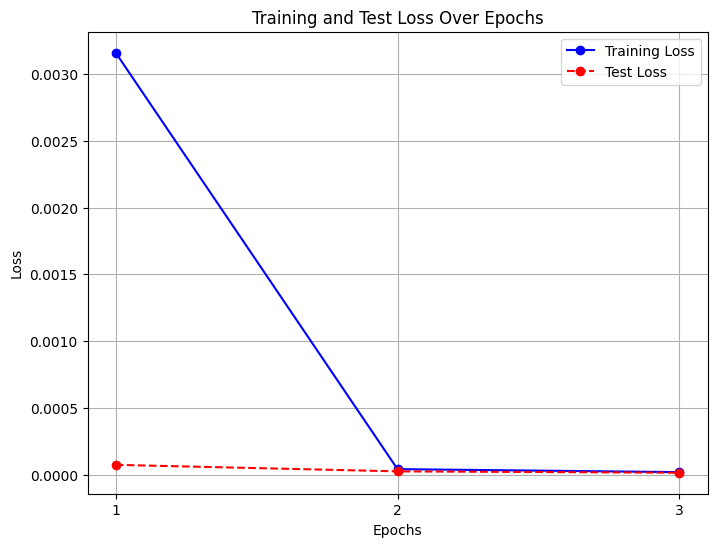

In [60]:
train_losses = [0.0031595947588453745, 4.171777431147107e-05, 1.9332615938644768e-05]
test_losses = [7.382233674374607e-05, 2.5040043764136975e-05, 1.4840485730884048e-05]
plot_loss(train_losses, test_losses)

In [ ]:
model_save_path = "cached_model/conv_autoencoder_omniglot_model_fv.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully to --> {model_save_path}")

In [63]:
model_save_path = "cached_model/conv_autoencoder_omniglot_model_fv.pth"
loaded_model = AutoEncoderImg()
loaded_model.load_state_dict(
    torch.load(model_save_path, map_location=torch.device("cpu"))
)

/tmp/ipykernel_1588900/2406711630.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path, map_location=torch.device("cpu

<All keys matched successfully>

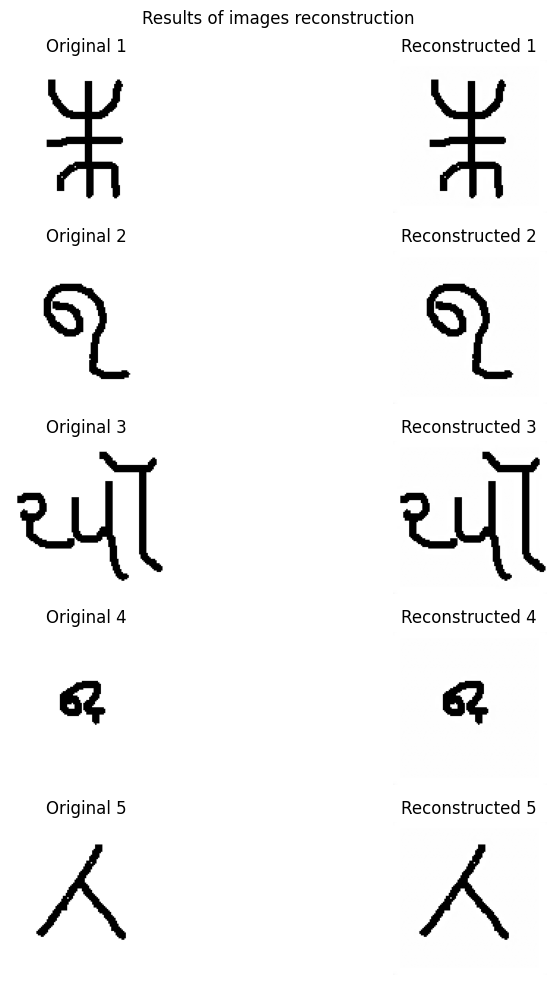

In [68]:
def plot_inference(
    model: AutoEncoderImg,
    data_loader: DataLoader,
    num_samples: int = 5,
    device: torch.device = torch.device("cpu"),
):
    """
    Selects random images from the dataset and plots them alongside their reconstructed images.
    """
    model.to(device)
    model.eval()
    # pick num_samples images from the dataset randomly
    samples = random.sample(list(data_loader.dataset), num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for idx, sample in enumerate(samples):
        img, _ = sample
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed_img = model(img)
        img = img.squeeze().cpu().numpy()
        reconstructed_img = reconstructed_img.squeeze().cpu().numpy()
        # plot the og images and their reconstructed img side by side
        axes[idx, 0].imshow(img, cmap="gray")
        axes[idx, 0].axis("off")
        axes[idx, 0].set_title(f"Original {idx + 1}")
        axes[idx, 1].imshow(reconstructed_img, cmap="gray")
        axes[idx, 1].axis("off")
        axes[idx, 1].set_title(f"Reconstructed {idx + 1}")
    plt.suptitle("Results of images reconstruction")
    plt.tight_layout()
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_inference(loaded_model, test_loader, num_samples=5, device=device)